# The Stingray Modeling API Explained

Some more in-depth explanations of how the Stingray modeling API works.

## Some background

Modeling power spectra and light curves with parametric models is a fairly standard task. Stingray aims to make solving these problems as easy as possible. 

We aim to integrate our existing code with `astropy.modeling` for for maximum compatibility. Please note, however, that we are only using the models, not the fitting interface, which is too constrained for our purposes. 



In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_palette("colorblind")
except ImportError:
    print("Install seaborn. It help you make prettier figures!")

import numpy as np

from astropy.modeling import models

The models and API of `astropy.modeling.models` is explained in the [astropy documentation](http://docs.astropy.org/en/stable/modeling/)in more detail.

Here's how you instantiate a simple 1-D Gaussian:

In [2]:
g = models.Gaussian1D()

<Container object of 3 artists>

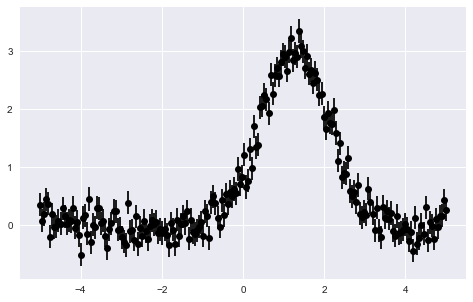

In [3]:
# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
yerr = 0.2

plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=yerr, fmt='ko')


## Likelihoods and Posteriors

In general, model fitting will happen either in a frequentist (Maximum Likelihood) or Bayesian framework. Stingray's strategy is to let the user define a posterior in both cases, but ignore the prior in the former case. 

Let's first make some fake data:

In [4]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

We're going to pick some fairly standard parameters for our data:

In [5]:
# parameters for fake data.
alpha = 2.0
amplitude = 5.0
white_noise = 2.0

And now a frequency array:

In [6]:
freq = np.linspace(0.01, 10.0, 10.0/0.01)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Now we can set the parameters in the model:

In [7]:
from astropy.modeling.fitting import _fitter_to_model_params

_fitter_to_model_params(plc, [amplitude, alpha, white_noise])


In [8]:
psd_shape = plc(freq)

As a last step, we need to add noise by picking from a chi-square distribution with 2 degrees of freedom:

In [9]:
powers = psd_shape*np.random.chisquare(2, size=psd_shape.shape[0])/2.0

Let's plot the result:

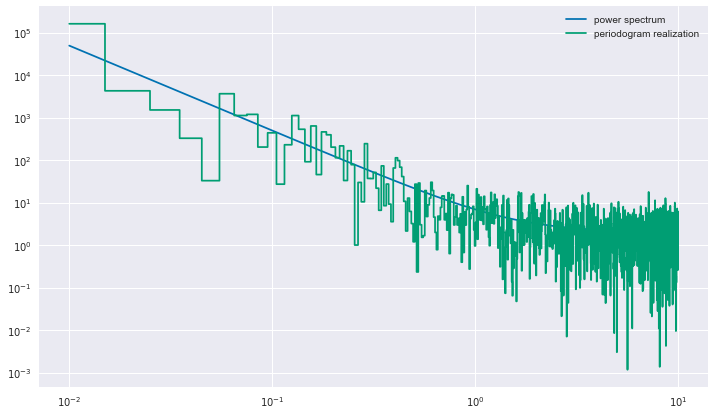

In [10]:
plt.figure(figsize=(12,7))
plt.loglog(freq, psd_shape, label="power spectrum")
plt.loglog(freq, powers, linestyle="steps-mid", label="periodogram realization")
plt.legend()

## Maximum Likelihood Fitting

Let's assume we've observed this periodogram from our source. We would now like to estimate the parameters. 
This requires the definition of *likelihood*, which describes the probability of observing the data plotted above given some underlying model with a specific set of parameters. To say it differently, the likelihood encodes what we know about the underlying model (here a power law and a constant) and the statistical properties of the data (power spectra generally follow a chi-square distribution) and then allows us to compare data and model for various parameters under the assumption of the statistical uncertainties.

In order to find the best parameter set, one generally maximizes the likelihood function using an optimization algorithm. Because optimization algorithms generally *minimize* functions, they effectively minimize the log-likelihood, which comes out to be the same as maximizing the likelihood itself.

Below is an implementation of the $\chi^2$ likelihood as appropriate for power spectral analysis, with comments for easier understanding. The same is also implemented in `posterior.py` in Stingray:

In [11]:
logmin = -1e16
class PSDLogLikelihood(object):

    def __init__(self, x, y, model, m=1):
        """
        A Chi-square likelihood as appropriate for power spectral analysis.

        Parameters
        ----------
        x : iterable
            x-coordinate of the data

        y : iterable
            y-coordinte of the data

        model: an Astropy Model instance
            The model to use in the likelihood.

        m : int
            1/2 of the degrees of freedom, i.e. the number of powers 
            that were averaged to obtain the power spectrum input into 
            this routine.

        """
        self.x = x # the x-coordinate of the data (frequency array)
        self.y = y # the y-coordinate of the data (powers)
        self.model = model # an astropy.models instance
        self.m = m # 1/2 of the degrees of freedom; 
        
        self.params = [k for k,l in self.model.fixed.items() if not l]
        self.npar = len(self.params) # number of free parameters

    def evaluate(self, pars, neg=False):
        """
        Evaluate the log-likelihood.
        
        Parameters
        ----------
        pars : iterable
            The list of parameters for which to evaluate the model.
            
        neg : bool, default False
            If True, compute the *negative* log-likelihood, otherwise 
            compute the *positive* log-likelihood.
        
        Returns
        -------
        loglike : float
            The log-likelihood of the model
        
        """
        # raise an error if the length of the parameter array input into 
        # this method doesn't match the number of free parameters in the model
        if np.size(pars) != self.npar:
            raise Exception("Input parameters must" +
                            " match model parameters!")

        # set parameters in self.model to the parameter set to be used for 
        # evaluation
        _fitter_to_model_params(self.model, pars)

        # compute the values of the model at the positions self.x
        mean_model = self.model(self.x)

        # if the power spectrum isn't averaged, compute simple exponential 
        # likelihood (chi-square likelihood for 2 degrees of freedom)
        if self.m == 1:
            loglike = -np.sum(np.log(mean_model)) - \
                      np.sum(self.y/mean_model)
        # otherwise use chi-square distribution to compute likelihood
        else:
            loglike = -2.0*self.m*(np.sum(np.log(mean_model)) +
                               np.sum(self.y/mean_model) +
                               np.sum((2.0 / (2. * self.m) - 1.0) *
                                      np.log(self.y)))

        if not np.isfinite(loglike):
            loglike = logmin

        if neg:
            return -loglike
        else:
            return loglike
        
    def __call__(self, parameters, neg=True):
        return self.evaluate(parameters, neg)


Let's make an object and see what it calculates if we put in different parameter sets:

In [12]:
loglike = PSDLogLikelihood(freq, powers, plc, m=1)

In [13]:
test_pars = [1, 5, 100]
loglike(test_pars)

4835.8821484746204

In [14]:
test_pars = [4.0, 10, 2.5]
loglike(test_pars)

2869.5582486265116

In [15]:
test_pars = [2.0, 5.0, 2.0]
loglike(test_pars)

2375.704120812954

Something close to the parameters we put in should yield the largest log-likelihood. Feel free to play around with the test parameters to verify that this is true.

You can similarly import the `PSDLogLikelihood` class from `stingray.modeling` and do the same:



In [16]:
from stingray.modeling import PSDLogLikelihood

loglike = PSDLogLikelihood(freq, powers, plc, m=1)
loglike(test_pars)

-2375.704120812954

To estimate the parameters, we can an optimization routine, such as those implemented in `scipy.optimize.minimize`.
We have wrapped some code around that, to make your lives easier. We will not reproduce the full code here, just demonstrate its functionality.

First, we have to make our sample PSD into an actual `Powerspectrum` object:

In [17]:
from stingray import Powerspectrum

In [18]:
ps = Powerspectrum()
ps.freq = freq
ps.power = powers
ps.df = ps.freq[1] - ps.freq[0]
ps.m = 1

Now we can instantiate the `PSDParEst` (for PSD Parameter Estimation) object. This can do more than simply optimize a single model, but we'll get to that later.

The `PSDParEst` object allows one to specify the fit method to use (however, this must be one of the optimizers in `scipy.optimize`). The parameter `max_post` allows for doing maximum-a-posteriori fits on the Bayesian posterior rather than maximum likelihood fits (see below for more details). We'll set it to `False` for now, since we haven't defined any priors:

In [31]:
from stingray.modeling import PSDParEst

parest = PSDParEst(ps, fitmethod="L-BFGS-B", max_post=False)

In order to fit a model, simply call the `fit` method with the model and starting parameters you would like to fit.

In [32]:
starting_pars = [3.0, 1.0, 2.4]
res = parest.fit(plc, starting_pars)

npar: 3


The result is an `OptimizationResults` object, which computes various summaries and useful quantities.

For example, here's the value of the likelihood function at the maximum the optimizer found:

In [33]:
res.result

2183.7896770356574

**Note**: Optimizers routinely get stuck in *local* minima (corresponding to local maxima of the likelihood function). It is usually useful to run an optimizer several times with different starting parameters in order to get close to the global maximum.

Most useful are the estimates of the parameters at the maximum likelihood and their uncertainties:

In [34]:
print(res.p_opt)
print(res.err)

[ 4.72915791  2.09193114  2.10372302]
[ 3.74677779  0.7290685   0.54642334]


**Note**: uncertainties are estimated here via the covariance matrix between parameters, i.e. the inverse of the Hessian at the maximum. This only represents the true uncertainties for specific assumptions about the likelihood function (Gaussianity), so use with care!

It also computes Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) for model comparison purposes:

In [35]:
print("AIC: " + str(res.aic))
print("BIC: " + str(res.bic))

AIC: 2189.78967704
BIC: 2204.51294287


Finally, it also produces the values of the mean function for the parameters at the maximum. Let's plot that and compare with the power spectrum we put in:

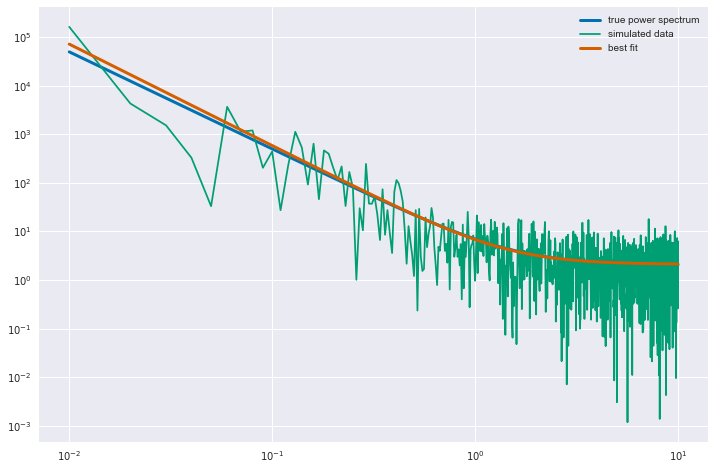

In [36]:
plt.figure(figsize=(12,8))
plt.loglog(ps.freq, psd_shape, label="true power spectrum",lw=3)
plt.loglog(ps.freq, ps.power, label="simulated data")
plt.loglog(ps.freq, res.mfit, label="best fit", lw=3)
plt.legend()

That looks pretty good!

You can print a summary of the fitting results by calling `print_summary`:

In [37]:
res.print_summary(loglike)

The best-fit model parameters plus errors are:
0) Parameter amplitude_0: 4.729158.5 +/- 3.746778.5f
1) Parameter alpha_0: 2.091931.5 +/- 0.729069.5f
2) Parameter amplitude_1: 2.103723.5 +/- 0.546423.5f


Fitting statistics: 
 -- number of data points: 1000
 -- Deviance [-2 log L] D = 4367.579354.3
 -- The Akaike Information Criterion of the model is: 2189.78967704.
 -- The Bayesian Information Criterion of the model is: 2204.51294287.
 -- The figure-of-merit function for this model  is: 1079.683208.5f and the fit for 997 dof is 1.082932.3f
 -- Summed Residuals S = 69267.044296.5f
 -- Expected S ~ 6000.000000.5 +/- 109.544512.5
 -- merit function (SSE) M = 1079.683208.5f 




### Likelihood Ratios

The parameter estimation code has more functionality than act as a simple wrapper around `scipy.optimize`. For example, it allows for easy computation of likelihood ratios.

To demonstrate that, let's make a broken power law model

In [38]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
bplc = bpl + c

In [39]:
bplc.param_names

('amplitude_0', 'x_break_0', 'alpha_1_0', 'alpha_2_0', 'amplitude_1')

In [40]:
# define starting parameters
bplc_start_pars = [2.0, 1.0, 3.0, 1.0, 2.5]

In [41]:
parest.compute_lrt(plc, starting_pars, bplc, bplc_start_pars)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:114: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


0.36021969359353534


## Bayesian Parameter Estimation

For Bayesian parameter estimation, we require a prior along with the likelihood defined above. Together, they form the *posterior*, the probability of the parameters given the data, which is what we generally want to compute in science.

Since there are no universally accepted priors for a model (they depend on the problem at hand and your physical knowledge about the system), they cannot be easily hard-coded in stingray. Consequently, setting priors is slightly more complex. 

Analogously to the `LogLikelihood` above, we can also define a `Posterior` object. Each posterior object has three methods: `logprior`, `loglikelihood` and `logposterior`. 

We have pre-defined some `Posterior` objects in `posterior.py` for common problems, including power spectral analysis. We start by making a `PSDPosterior` object:

In [42]:
from stingray.modeling import PSDPosterior

In [43]:
lpost = PSDPosterior(ps, plc)

The priors are set as a dictionary of functions:

In [44]:
import scipy.stats

# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((0.01 <= amplitude) & (amplitude <= 10.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise


There's a function `set_logprior` in `stingray.modeling` that sets the prior correctly:

In [45]:
from stingray.modeling import set_logprior

In [46]:
lpost.logprior = set_logprior(lpost, priors)

You can also set the priors when you instantiate the posterior object:

In [47]:
lpost = PSDPosterior(ps, plc, priors=priors)

Much like before with the log-likelihood, we can now also compute the log-posterior for various test parameter sets:

In [48]:
test_pars = [1.0, 2.0, 4.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: -198.61635344
log-likelihood: -2412.24935946
log-posterior: -2610.8657129


When the prior is zero (so the log-prior is -infinity), it automatically gets set to a very small value in order to avoid problems when doing the optimization:

In [49]:
test_pars = [6, 6, 3.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: -1e+16
log-likelihood: -2534.05678262
log-posterior: -1e+16


/Users/danielahuppenkothen/work/repositories/stingray/stingray/modeling/posterior.py:128: RuntimeWarning: divide by zero encountered in log
  logp += np.log(priors[pname](t0[ii]))


In [50]:
test_pars = [5.0, 2.0, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: 1.38364655979
log-likelihood: -2184.67395364
log-posterior: -2183.29030708


We can do the same parameter estimation as above, except now it's called maximum-a-posteriori instead of maximum likelihood and includes the prior:

In [51]:
parest = PSDParEst(ps, fitmethod='BFGS', max_post=True)
res = parest.fit(plc, starting_pars, priors=priors)

/Users/danielahuppenkothen/work/repositories/stingray/stingray/modeling/posterior.py:318: RuntimeWarning: invalid value encountered in log
  loglike = -np.sum(np.log(mean_model)) - \
/Users/danielahuppenkothen/work/repositories/stingray/stingray/modeling/posterior.py:128: RuntimeWarning: divide by zero encountered in log
  logp += np.log(priors[pname](t0[ii]))


In [52]:
print("best-fit parameters:")
for p,e in zip(res.p_opt, res.err):
    print("%.4f +/- %.4f"%(p,e))

best-fit parameters:
4.8949 +/- 0.5649
2.0690 +/- 0.0860
2.0547 +/- 0.0696


The same outputs exist as for the Maximum Likelihood case:

In [53]:
res.print_summary(lpost)

The best-fit model parameters plus errors are:
0) Parameter amplitude_0: 4.894908.5 +/- 0.564932.5f
1) Parameter alpha_0: 2.068983.5 +/- 0.086031.5f
2) Parameter amplitude_1: 2.054709.5 +/- 0.069586.5f


Fitting statistics: 
 -- number of data points: 1000
 -- Deviance [-2 log L] D = 4367.845865.3
 -- The Akaike Information Criterion of the model is: 2188.6889410986455.
 -- The Bayesian Information Criterion of the model is: 2203.41220694.
 -- The figure-of-merit function for this model  is: 1104.687008.5f and the fit for 997 dof is 1.108011.3f
 -- Summed Residuals S = 75870.939105.5f
 -- Expected S ~ 6000.000000.5 +/- 109.544512.5
 -- merit function (SSE) M = 1104.687008.5f 




Unlike in the maximum likelihood case, we can also *sample* from the posterior probability distribution. The method `sample` uses the [emcee]() package to do MCMC. 

**Note**: Do *not* sample from the likelihood function. This is formally incorrect and can lead to incorrect inferences about the problem!

Much like the optimizer, the sampling method requires a model and a set of starting parameters `t0`. Optionally, it can be useful to also input a covariance matrix, for example from the output of the optimizer.

Finally, the user should specify the number of walkers as well as the number of steps to use for both burn-in and sampling:


In [56]:
sample = parest.sample(plc, res.p_opt, cov=res.cov, priors=priors, nwalkers=500,
             niter=100, burnin=200, namestr="psd_modeling_test")

Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.646180.5
R_hat for the parameters is: [ 0.32098944  0.00725128  0.0045778 ]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 4.95334091124	0.568275869782	3.25699022148	3.69817069396

theta[1] 	 2.07590849754	0.0854098381958	1.82243748485	1.88712165725

theta[2] 	 2.05317824739	0.0678664544072	1.84965712284	1.89701432686



The sampling method returns an object with various attributes that are useful for further analysis, for example the acceptance fraction:

In [58]:
sample.acceptance

0.64618000000000009

Or the mean and confidence intervals of the parameters:

In [59]:
sample.mean

array([ 4.95334091,  2.0759085 ,  2.05317825])

In [60]:
sample.ci

array([[ 3.25699022,  1.82243748,  1.84965712],
       [ 3.69817069,  1.88712166,  1.89701433]])

The method `print_results` prints the results:

In [61]:
sample.print_results()

-- The acceptance fraction is: 0.646180.5
R_hat for the parameters is: [ 0.32098944  0.00725128  0.0045778 ]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 4.95334091124	0.568275869782	3.25699022148	3.69817069396

theta[1] 	 2.07590849754	0.0854098381958	1.82243748485	1.88712165725

theta[2] 	 2.05317824739	0.0678664544072	1.84965712284	1.89701432686



Similarly, the method `plot_results` produces a bunch of plots:

In [62]:
sample.plot_results("modeling_tutorial_mcmc_corner.pdf")

## Convenience Function

For convenience, we have implemented some simple functions to reduce overhead with having to instantiate objects of the various classes.

Note that these convenience function use similar approaches and guesses in all cases; this might work for some simple quicklook analysis, but when preparing publication-ready results, one should approach the analysis with more care and make sure the options chosen are appropriate for the problem at hand.

### Fitting Lorentzians

Fitting Lorentzians to power spectra is a routine task for most astronomers working with power spectra, hence there is a function that can produce either Maximum Likelihood or Maximum-A-Posteriori fits of the data.

In [70]:
l = models.Lorentz1D

In [71]:
l.param_names

('amplitude', 'x_0', 'fwhm')

In [137]:
def fit_lorentzians(ps, nlor, starting_pars, fit_whitenoise=True, max_post=False, priors=None,
                    fitmethod="L-BFGS-B"):
    
    model = models.Lorentz1D()
    
    if nlor > 1:
        for i in range(nlor-1):
            model += models.Lorentz1D()
            
    if fit_whitenoise:
        model += models.Const1D()
    
    parest = PSDParEst(ps, fitmethod=fitmethod, max_post=max_post)
    res = parest.fit(model, starting_pars, neg=True, priors=priors)
    
    return parest, res

Let's make a dataset so we can test it!

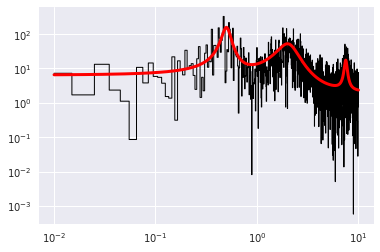

In [138]:
np.random.seed(400)
nlor = 3

x_0_0 = 0.5
x_0_1 = 2.0
x_0_2 = 7.5

amplitude_0 = 150.0
amplitude_1 = 50.0
amplitude_2 = 15.0

fwhm_0 = 0.1
fwhm_1 = 1.0
fwhm_2 = 0.5

whitenoise = 2.0

model = models.Lorentz1D(amplitude_0, x_0_0, fwhm_0) + \
        models.Lorentz1D(amplitude_1, x_0_1, fwhm_1) + \
        models.Lorentz1D(amplitude_2, x_0_2, fwhm_2) + \
        models.Const1D(whitenoise)
        
p = model(ps.freq)
noise = np.random.exponential(size=len(ps.freq))

power = p*noise

plt.figure()
plt.loglog(ps.freq, power, lw=1, linestyle="steps-mid", c="black")
plt.loglog(ps.freq, p, lw=3, color="red")

Let's make this into a `Powerspectrum` object:

In [139]:
import copy

In [140]:
ps_new = copy.copy(ps)

In [141]:
ps_new.power = power

So now we can fit this model with our new function, but first, we need to define the starting parameters for our fit. The starting parameters will be `[amplitude, x_0, fwhm]` for each component plus the white noise component at the end:

In [146]:
t0 = [150, 0.4, 0.2, 50, 2.3, 0.6, 20, 8.0, 0.4, 2.1]
parest, res = fit_lorentzians(ps_new, nlor, t0)

10


Let's look at the output:

In [147]:
res.p_opt

array([  1.48618601e+02,   4.85309532e-01,   1.16289287e-01,
         3.99339116e+01,   2.07688123e+00,   1.11819445e+00,
         1.36761112e+01,   7.53307692e+00,   5.53395515e-01,
         1.90341056e+00])

Cool, that seems to work! For convenience `PSDParEst` also has a plotting function:

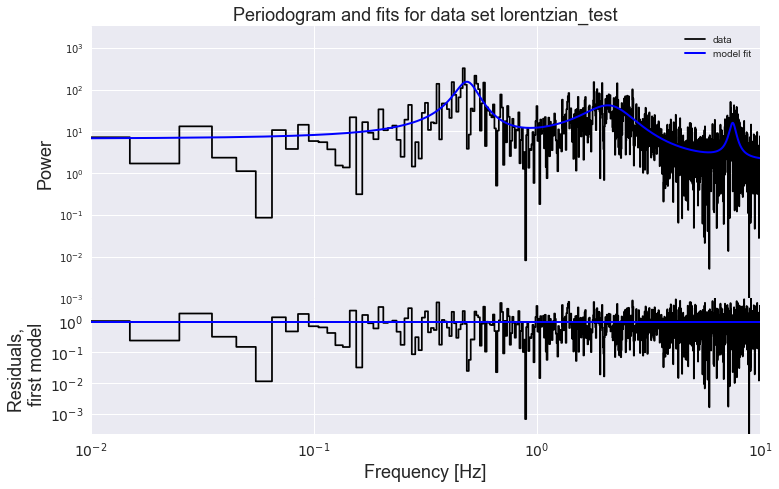

In [154]:
parest.plotfits(res, save_plot=False, namestr="lorentzian_test")

The function exists in the library as well for ease of use:

In [156]:
from stingray.modeling import fit_lorentzians

In [158]:
parest, res = fit_lorentzians(ps_new, nlor, t0)

In [159]:
res.p_opt

array([  1.48264667e+02,   4.85309402e-01,   1.16463939e-01,
         3.99347744e+01,   2.07689790e+00,   1.11811197e+00,
         1.36772599e+01,   7.53307220e+00,   5.53313592e-01,
         1.90357433e+00])

And we're done!